In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano 
from scipy.stats import norm
from scipy.stats import t

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

# Configureation

In [40]:
#h1
h1_do_obs                = True
h1_do_bern               = True
resample_h1_obs          = False
resample_h1_bern         = False
folderName_h1_obs        = "h1_obs.trace"
folderName_h1_bern       = "h1_bern.trace"

#h2
h2_do_linear             = True
h2_do_quadratic          = True
resample_h2_linear       = False
resample_h2_quadratic    = False
folderName_h2_linear     = "h2_linear.trace"
folderName_h2_quadratic  = "h2_quadratic.trace"

describeData             = False

remove_rows_not_cells    = True
h1_ropes                 = [("diff_μ", (-0.25, 0.25)) ]
var_names_h1_notRope     = ['log10_ν', 'μ', 'σ', 'diff_σ']
var_names_h1_all         = var_names_h1_notRope.copy().extend([name for name,rope in h1_ropes])

# Helperfunctions

In [3]:
def flatten(lst):
    res = []
    for inner in lst:
        for v in inner:
            res.append(v)
    return res

def getIndexV27(): return 0
def getIndexV28(): return 1
def getIndexV29(): return 2
def getIndexV30(): return 3
def getIndexV31(): return 4
def getIndexV32(): return 5
def getIndexV33(): return 6

In [4]:
def getTrace(folder_name, model_name, resample):
    with model_name:
        if (resample):
            trace = pm.sample(10000, chains=4, cores=1, step=pm.NUTS())  #todo argue for choice
            pm.save_trace(trace, folder_name, overwrite=True)
        trace = pm.load_trace(folder_name)
        return trace

def getInferenceData(trace, model_name):
    with model_name:
        return az.from_pymc3(trace, model = model_name)

def standardize(data, m, sd):
    return (data-m)/sd

In [5]:
def plot_trace_method1(trace_inferencedata, var_names, ropes):
    az.plot_posterior(trace_inferencedata, var_names=var_names, kind='hist', figsize=(8,6)
                      , point_estimate='mean', hdi_prob=0.95);
    for (name, rope) in ropes:
        az.plot_posterior(trace_inferencedata, var_names=[name], kind='hist', figsize=(8,2.5)
                      , point_estimate='mean', hdi_prob=0.95, ref_val=0, rope=rope);

def plot_trace_method2(trace, model, var_names):
    az.plot_trace(az.from_pymc3(trace,model=model), var_names=var_names);

def plot_trace_scatter(trace, varnames):
    scatter_matrix(pm.trace_to_dataframe(trace, varnames=varnames), figsize=(20, 10));

def plot_all_data(f_x):
    fig,ax = plt.subplots(figsize=(25,20))
    xprime = np.linspace(1,5,80)
    for i in np.random.randint(0,len(trace_h2_linear),100):
        ax.plot(xprime, f_x(xprime, i), color='lightsteelblue')

    # Define spectrum of colors
    number_of_plots=len(communities)
    colormap = plt.cm.nipy_spectral
    colors = [colormap(i) for i in np.linspace(0, 1,number_of_plots)]
    ax.set_prop_cycle('color', colors)

    [ax.plot(get_relevant(com, 2)[1], get_relevant(com, 4)[1], "-", marker='o', label=com) for com in communities]

    plt.legend(loc='best')
    plt.show()

# load data

In [6]:
df = pd.read_csv('pseudonymized-data.csv')
df = df.rename(columns={df.columns[0]: 'id'})
df = df[df["Community"] != "-1"]

if remove_rows_not_cells:
    for col in df.iloc[:,2:].columns:
        df = df[df[col] != -1]

In [7]:
def removeNoAnswer(lst):
    return lst if remove_rows_not_cells else [i for i in lst if i!=-1]

data = []
communities = df.Community.unique();
for com in communities:
    columns  = []
    for question in df.iloc[:,2:].columns:
        columns.append(removeNoAnswer(df[df.Community == com][question].to_numpy()))
    positive = [[int(d<=3) for d in v] for v in columns]

    N = [len(v) for v in columns]
    μ = [np.mean(v) for v in columns]
    σ = [np.std(v) for v in columns]
    
    N_bern = [len(v) for v in positive]
    μ_bern = [np.mean(v) for v in positive]
    σ_bern = [np.std(v) for v in positive]
    all = (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern)
    data.append(all)

def get_all_data ():
    return data
    
def get_relevant(com, dataIndex):
    (com, columns, positive, N, μ, σ, N_bern, μ_bern, σ_bern) = next(filter(lambda lst : lst[0]==com, data))
    return (com, columns[dataIndex], positive[dataIndex], N[dataIndex], μ[dataIndex], σ[dataIndex], N_bern[dataIndex], μ_bern[dataIndex], σ_bern[dataIndex])

In [8]:
df.head() if describeData else None

In [9]:
df.iloc[:,2:].describe() if describeData else None

In [10]:
if describeData:
    df.hist(column=df.columns[1:], bins=50, figsize=(20,10))
    plt.show()

### H1
The Coala Community is more lenient than the Linux Kernel Community.

#### Decision Rules - for reference
The basic principle 
 
- Decision Rule 1. If the null value is far from credible values: reject the hypothesis 
- Decision Rule 2. If all credible values are practically equivalent to the null value: accept the hypothesis 
- **Example.** If we want to prove that a coin is biased, we want to reject the null value of 0.5

Null value - draft
- The Likert scale value of Coala community is greater than that of Linux Kernel Community
- The difference is non zero - 95% HDI of difference doesn't overlap with ROPE of zero - (maybe +-.25 of the scale ~0.05%)
- Our null hypothesis is that the Coala Community is more lenient than the Linux Kernel Community if **(μ_coala - μ_linux) > 0 ± 0.25**

In [11]:
(com_coala, obs_coala, bern_coala, N_coala_obs, μ_coala_obs, σ_coala_obs, N_coala_bern, μ_coala_bern, σ_coala_bern)=get_relevant("Comm.Coala", getIndexV33())
(com_linux, obs_linux, bern_linux, N_linux_obs, μ_linux_obs, σ_linux_obs, N_linux_bern, μ_linux_bern, σ_linux_bern)=get_relevant("Comm.Linux_Kernel", getIndexV33())

if describeData:
    print("col: ",col_coala,col_linux)
    print("N: ",N_coala,N_linux)
    print("μ: ",μ_coala,μ_linux)
    print("σ: ",σ_coala,σ_linux)
    print("p: ",bern_coala,bern_linux)
    print("N: ",N_coala_bern,N_linux_bern)
    print("μ: ",μ_coala_bern,μ_linux_bern)
    print("σ: ",σ_coala_bern,σ_linux_bern)

### H1 Model description

In [12]:
def makeModel(data_coala, data_linux, data_μ_coala, data_μ_linux, data_σ_coala, data_σ_linux):
    data_σ_coala = np.max([1/1000,data_σ_coala])
    data_σ_linux = np.max([1/1000,data_σ_linux])
    with pm.Model() as model_h1:
        μ_noData = pm.Normal('μ_noData', mu=1, sigma=100*1, shape=2)
        μ        = pm.Deterministic('μ', μ_noData*[data_μ_coala, data_μ_linux])
        σ_noData = pm.Uniform('σ_noData', lower=1/1000, upper=1*1000, shape=2)
        σ        = pm.Deterministic('σ', σ_noData*[data_σ_coala, data_σ_linux])
        ν_minus_one = pm.Exponential('ν_minus_one', lam=1/29)
        ν = pm.Deterministic('ν', ν_minus_one+1)

        # for plotting/comparison purposes
        log10_ν = pm.Deterministic('log10_ν',np.log10(ν))
        eff_size = pm.Deterministic('eff_size',(μ-100)/σ)

        #likelihood
        obs_coala   = pm.StudentT('obs_coala',  nu=ν, mu=μ[0], sd=σ[0], observed=data_coala)
        obs_linux   = pm.StudentT('obs_linux',  nu=ν, mu=μ[1], sd=σ[1], observed=data_linux)

        #differences
        diff_μ   = pm.Deterministic('diff_μ', μ[0]-μ[1])
        diff_σ   = pm.Deterministic('diff_σ', σ[0]-σ[1])
    return model_h1

In [13]:
model_h1_obs  = makeModel(obs_coala,  obs_linux,  μ_coala_obs,  μ_linux_obs,  σ_coala_obs,  σ_linux_obs)  if h1_do_obs else None
model_h1_bern = makeModel(bern_coala, bern_linux, μ_coala_bern, μ_linux_bern, σ_coala_bern, σ_linux_bern) if h1_do_bern else None

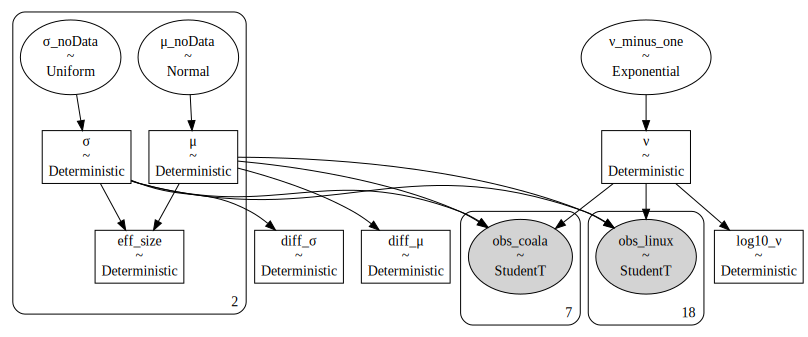

In [14]:
pm.model_to_graphviz(model_h1_obs)  if h1_do_obs else None

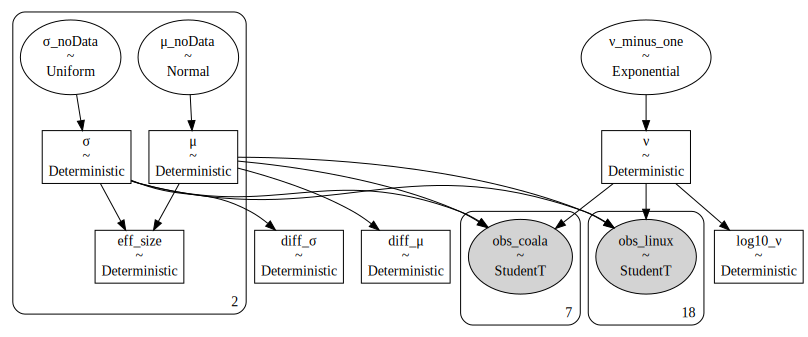

In [15]:
pm.model_to_graphviz(model_h1_bern) if h1_do_bern else None

In [16]:
trace_h1_obs = getTrace(folderName_h1_obs,  model_h1_obs,  resample_h1_obs)  if h1_do_obs else None
trace_h1_inferencedata_obs = getInferenceData(trace_h1_obs, model_h1_obs)    if h1_do_obs else None

In [17]:
trace_h1_bern = getTrace(folderName_h1_bern, model_h1_bern, resample_h1_bern) if h1_do_bern else None
trace_h1_inferencedata_bern = getInferenceData(trace_h1_bern, model_h1_bern)  if h1_do_bern else None

### H1 Model analysis

In [18]:
az.summary(trace_h1_obs)  if h1_do_obs  else None

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.012,0.145,0.738,1.282,0.001,0.001,22011.0,18975.0,1.0
μ_noData[1],1.004,0.081,0.851,1.155,0.000,0.000,27232.0,23875.0,1.0
μ[0],1.734,0.249,1.265,2.198,0.002,0.001,22011.0,18975.0,1.0
μ[1],2.899,0.235,2.457,3.337,0.001,0.001,27232.0,23875.0,1.0
σ_noData[0],1.346,0.571,0.570,2.406,0.004,0.003,14668.0,8581.0,1.0
σ_noData[1],1.076,0.215,0.704,1.477,0.001,0.001,23585.0,20834.0,1.0
σ[0],0.608,0.258,0.257,1.087,0.002,0.001,14668.0,8581.0,1.0
σ[1],0.942,0.188,0.616,1.293,0.001,0.001,23585.0,20834.0,1.0
ν_minus_one,34.977,30.304,0.031,89.614,0.182,0.129,14736.0,8356.0,1.0
ν,35.977,30.304,1.031,90.614,0.182,0.129,14736.0,8356.0,1.0


In [19]:
az.summary(trace_h1_bern) if h1_do_bern else None

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_noData[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,22364.0,16873.0,1.0
μ_noData[1],1.385000e+00,0.000000e+00,1.384000e+00,1.385000e+00,0.000,0.000,32387.0,23255.0,1.0
μ[0],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,22364.0,16873.0,1.0
μ[1],1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000,0.000,32387.0,23255.0,1.0
σ_noData[0],1.000000e-03,0.000000e+00,1.000000e-03,2.000000e-03,0.000,0.000,20368.0,15716.0,1.0
σ_noData[1],1.000000e-03,0.000000e+00,1.000000e-03,2.000000e-03,0.000,0.000,26889.0,18093.0,1.0
σ[0],0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000,0.000,20368.0,15716.0,1.0
σ[1],1.000000e-03,0.000000e+00,0.000000e+00,1.000000e-03,0.000,0.000,26889.0,18093.0,1.0
ν_minus_one,3.600000e-02,3.500000e-02,0.000000e+00,9.900000e-02,0.000,0.000,25207.0,14941.0,1.0
ν,1.036000e+00,3.500000e-02,1.000000e+00,1.099000e+00,0.000,0.000,25207.0,14941.0,1.0


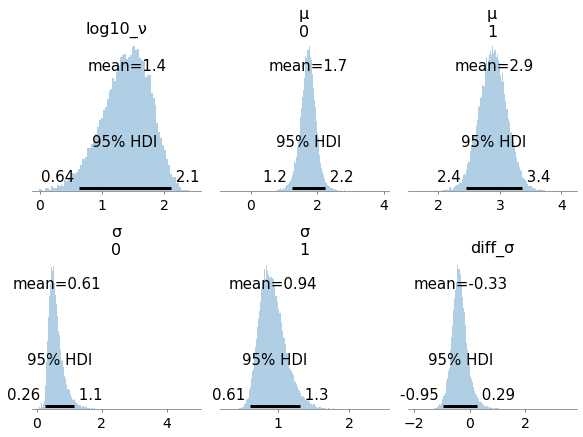

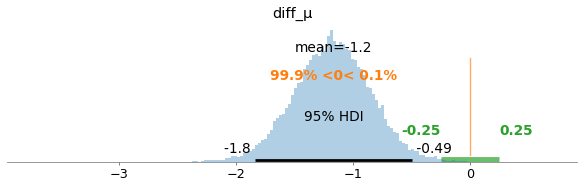

In [20]:
plot_trace_method1(trace_h1_inferencedata_obs,  var_names_h1_notRope, h1_ropes) if h1_do_obs  else None

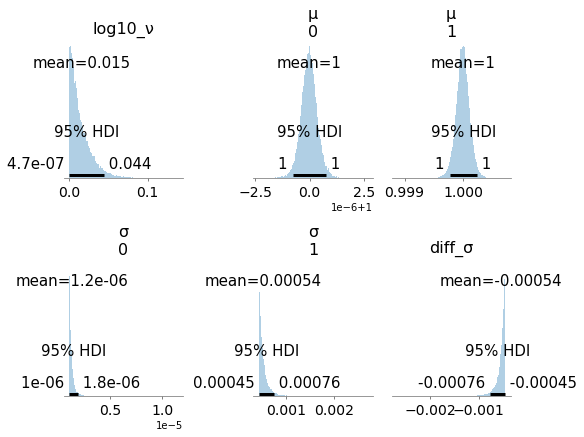

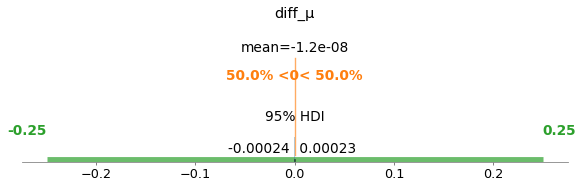

In [21]:
plot_trace_method1(trace_h1_inferencedata_bern, var_names_h1_notRope, h1_ropes) if h1_do_bern else None

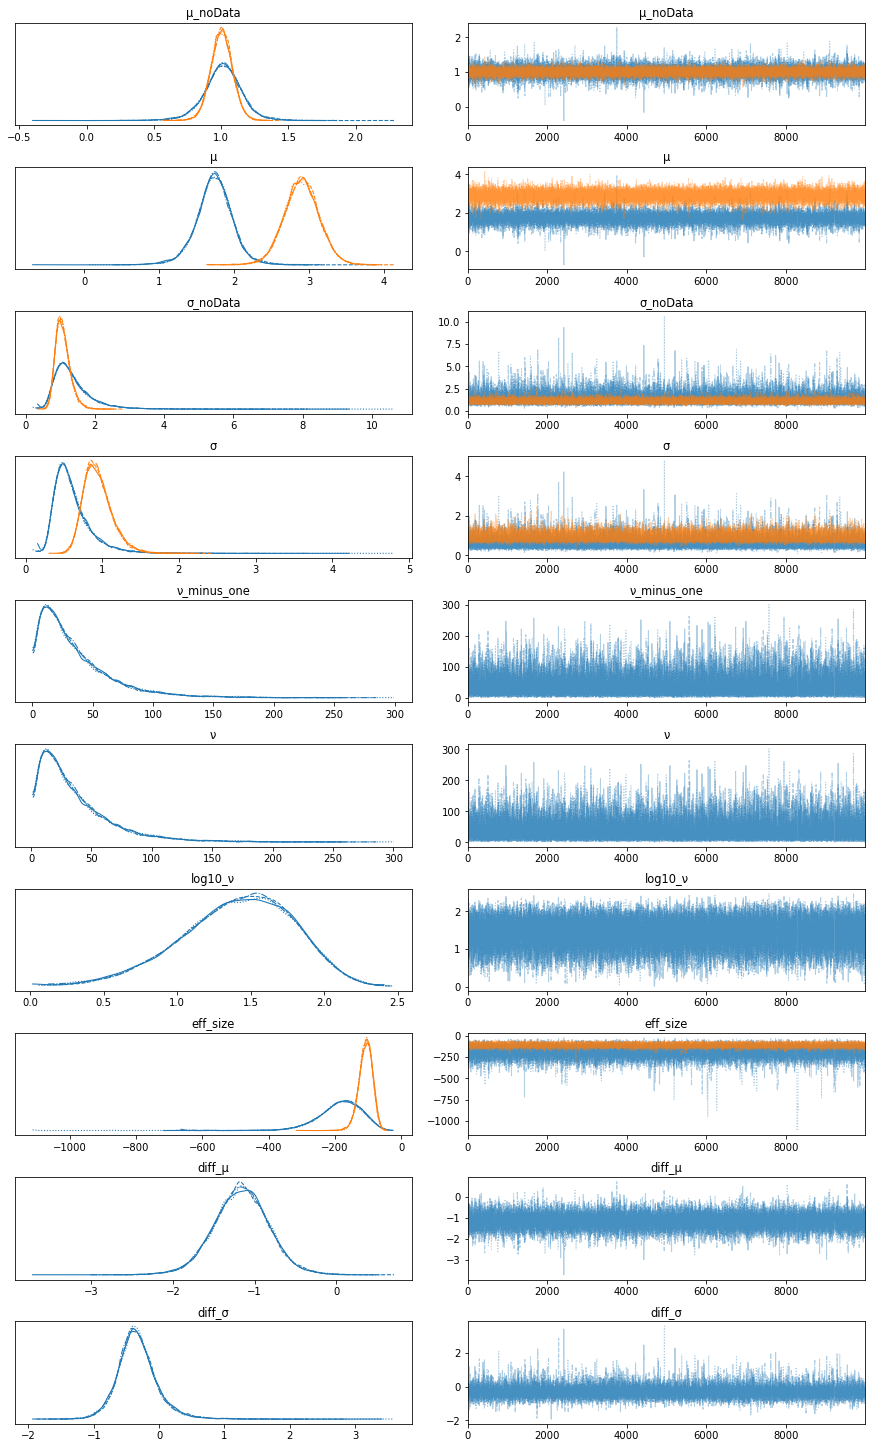

In [22]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

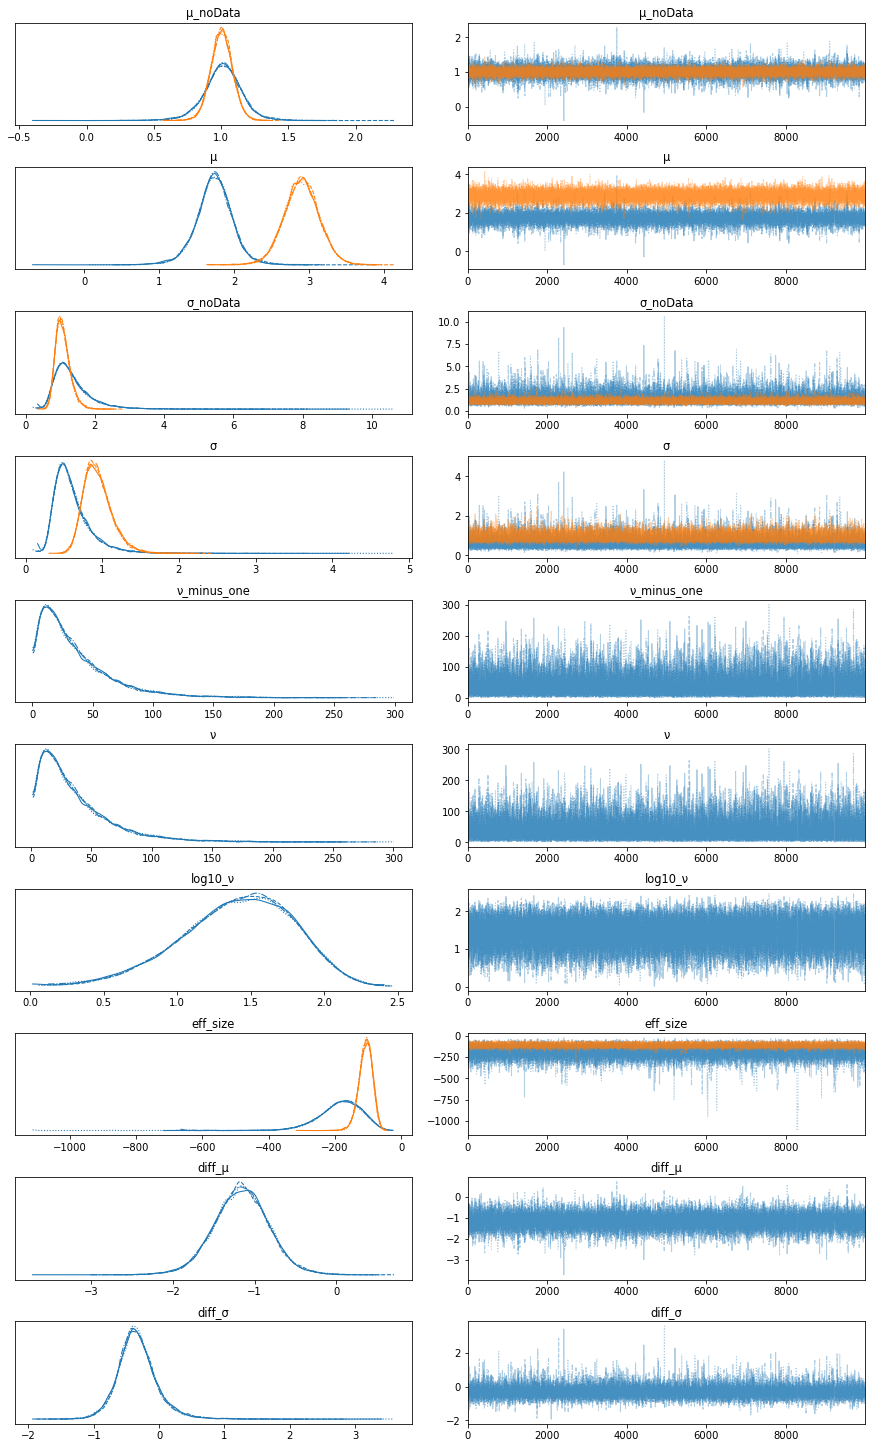

In [23]:
plot_trace_method2(trace_h1_obs, model_h1_obs, var_names_h1_all) if h1_do_obs  else None

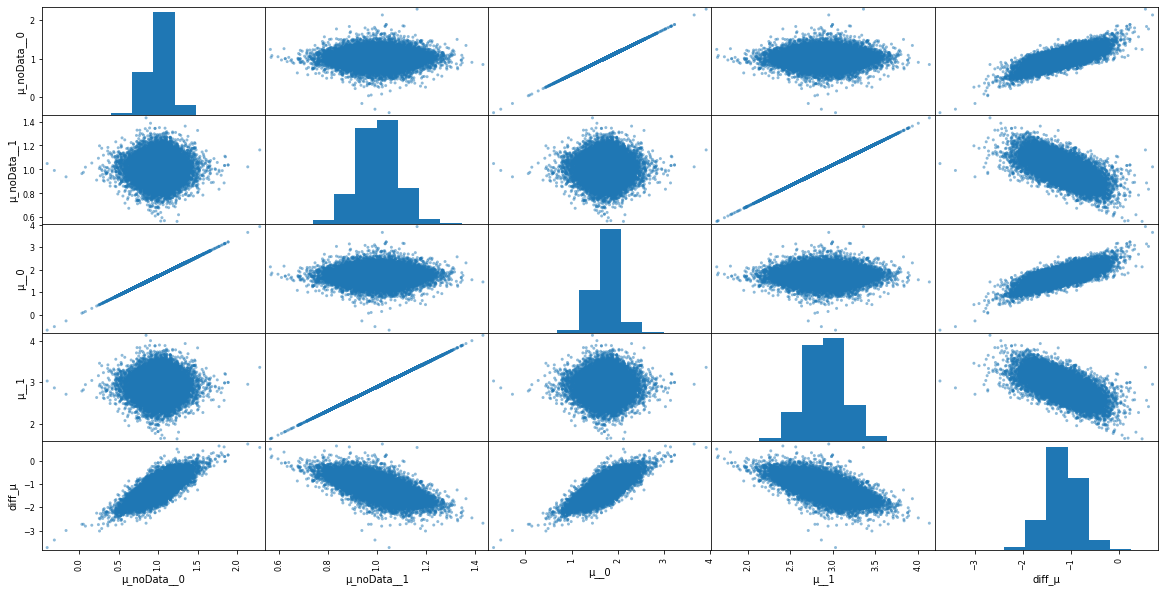

In [24]:
plot_trace_scatter(trace_h1_obs, ['μ_noData', 'μ', 'diff_μ'])

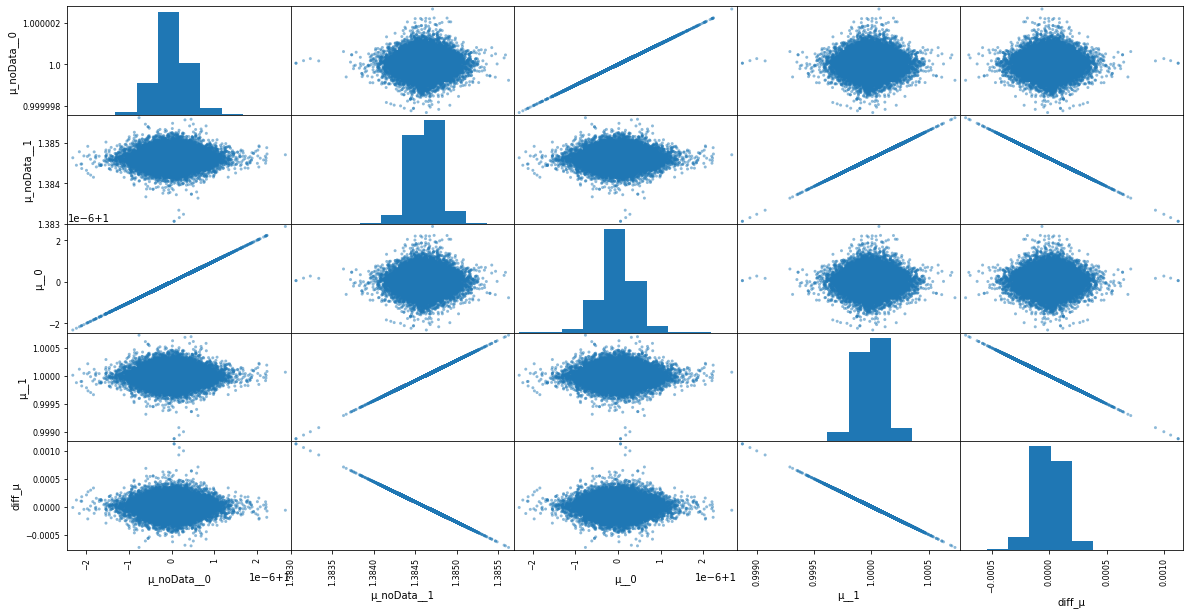

In [25]:
plot_trace_scatter(trace_h1_bern, ['μ_noData', 'μ', 'diff_μ'])

## H2

All communities show either a protective or equitable style of governance for pull requests (so for each community answers to V29 and V31 are different)

## Model h2

In [26]:
V29_norm = flatten([get_relevant(com, getIndexV29())[1] for com in communities])
V31_norm = flatten([get_relevant(com, getIndexV31())[1] for com in communities])
idxs = flatten([[i for v in get_relevant(com, getIndexV29())[1]] for (i,com) in enumerate(communities)])
com_ids = range(len(communities))
m_29 = np.mean(V29_norm)
m_31 = np.mean(V31_norm)
sd_29 = np.std(V29_norm)
sd_31 = np.std(V31_norm)
V29 = standardize(V29_norm, m_29, sd_29)
V31 = standardize(V31_norm, m_31, sd_31)

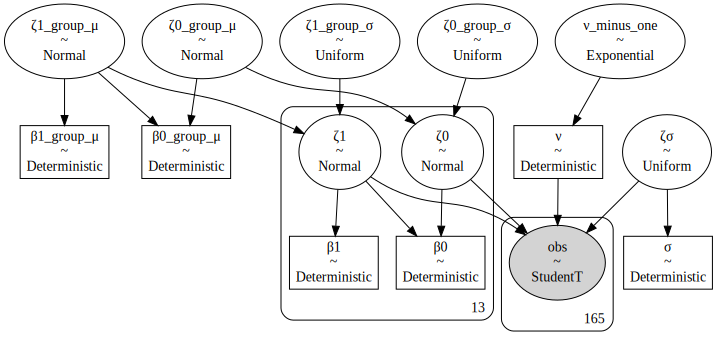

In [27]:
with pm.Model() as model_h2_linear:
    # Prior
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    
    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)
    
    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    
    
    pm.StudentT('obs',
            nu=ν,
            mu=ζ0[idxs]+ζ1[idxs]*V29,
            sigma=ζσ,
            observed=V31)
    
    #transforming data back
    β0 = pm.Deterministic('β0', (ζ0*sd_31) + m_31 - (ζ1*m_29*sd_31/sd_29))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29)
    
    
    β0_group_μ = pm.Deterministic('β0_group_μ', (ζ0_group_μ*sd_31) + m_31 - (ζ1_group_μ*m_29*sd_31/sd_29))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29)

    σ = pm.Deterministic('σ', ζσ)

pm.model_to_graphviz(model_h2_linear)

In [28]:
trace_h2_linear = getTrace(folderName_h2_linear, model_h2_linear, resample_h2_linear)  if h2_do_linear else None
trace_h2_inferencedata_linear = getInferenceData(trace_h2_linear, model_h2_linear)     if h2_do_linear else None

In [29]:
az.summary(trace_h2_linear) if h2_do_linear else None

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,0.001,0.158,-0.305,0.295,0.002,0.002,4586.0,3159.0,1.0
ζ1_group_μ,-0.123,0.116,-0.345,0.091,0.001,0.001,8437.0,13670.0,1.0
ζ0[0],-0.380,0.173,-0.715,-0.066,0.002,0.002,5809.0,6353.0,1.0
ζ0[1],0.100,0.185,-0.237,0.452,0.003,0.002,4301.0,2850.0,1.0
ζ0[2],0.012,0.273,-0.500,0.526,0.003,0.002,11236.0,12240.0,1.0
...,...,...,...,...,...,...,...,...,...
β1[11],-0.041,0.119,-0.265,0.183,0.001,0.001,10591.0,20337.0,1.0
β1[12],-0.165,0.196,-0.559,0.187,0.002,0.001,10797.0,18509.0,1.0
β0_group_μ,2.542,0.469,1.663,3.433,0.005,0.004,7895.0,14616.0,1.0
β1_group_μ,-0.117,0.110,-0.328,0.086,0.001,0.001,8437.0,13670.0,1.0


In [30]:
var_names_h2=['β0_group_μ','β1_group_μ','ν']

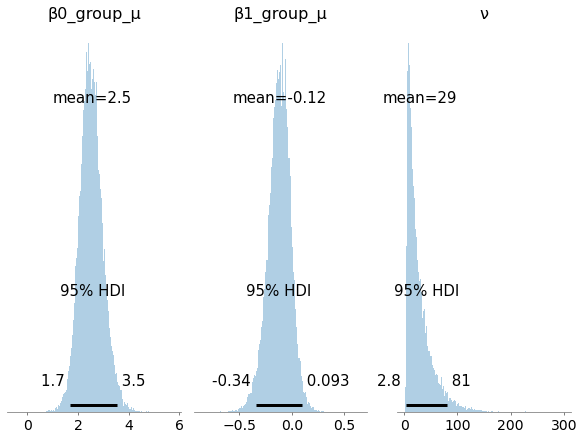

In [31]:
plot_trace_method1(trace_h2_inferencedata_linear, var_names_h2, [])

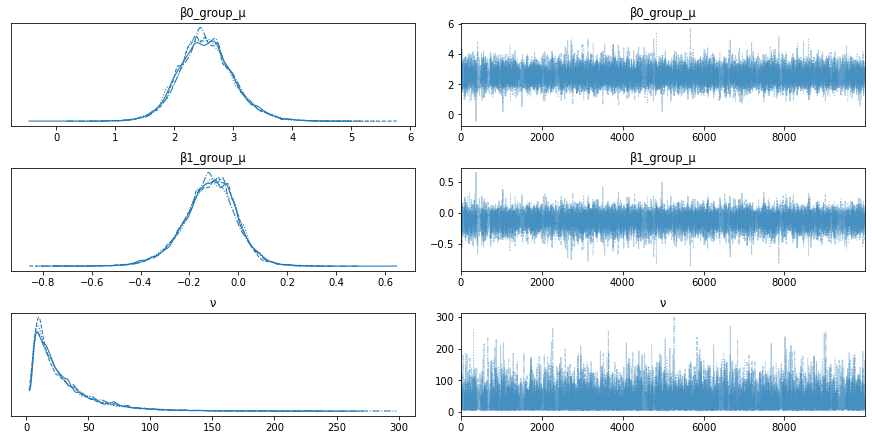

In [32]:
plot_trace_method2(trace_h2_linear, model_h2_linear, var_names_h2)

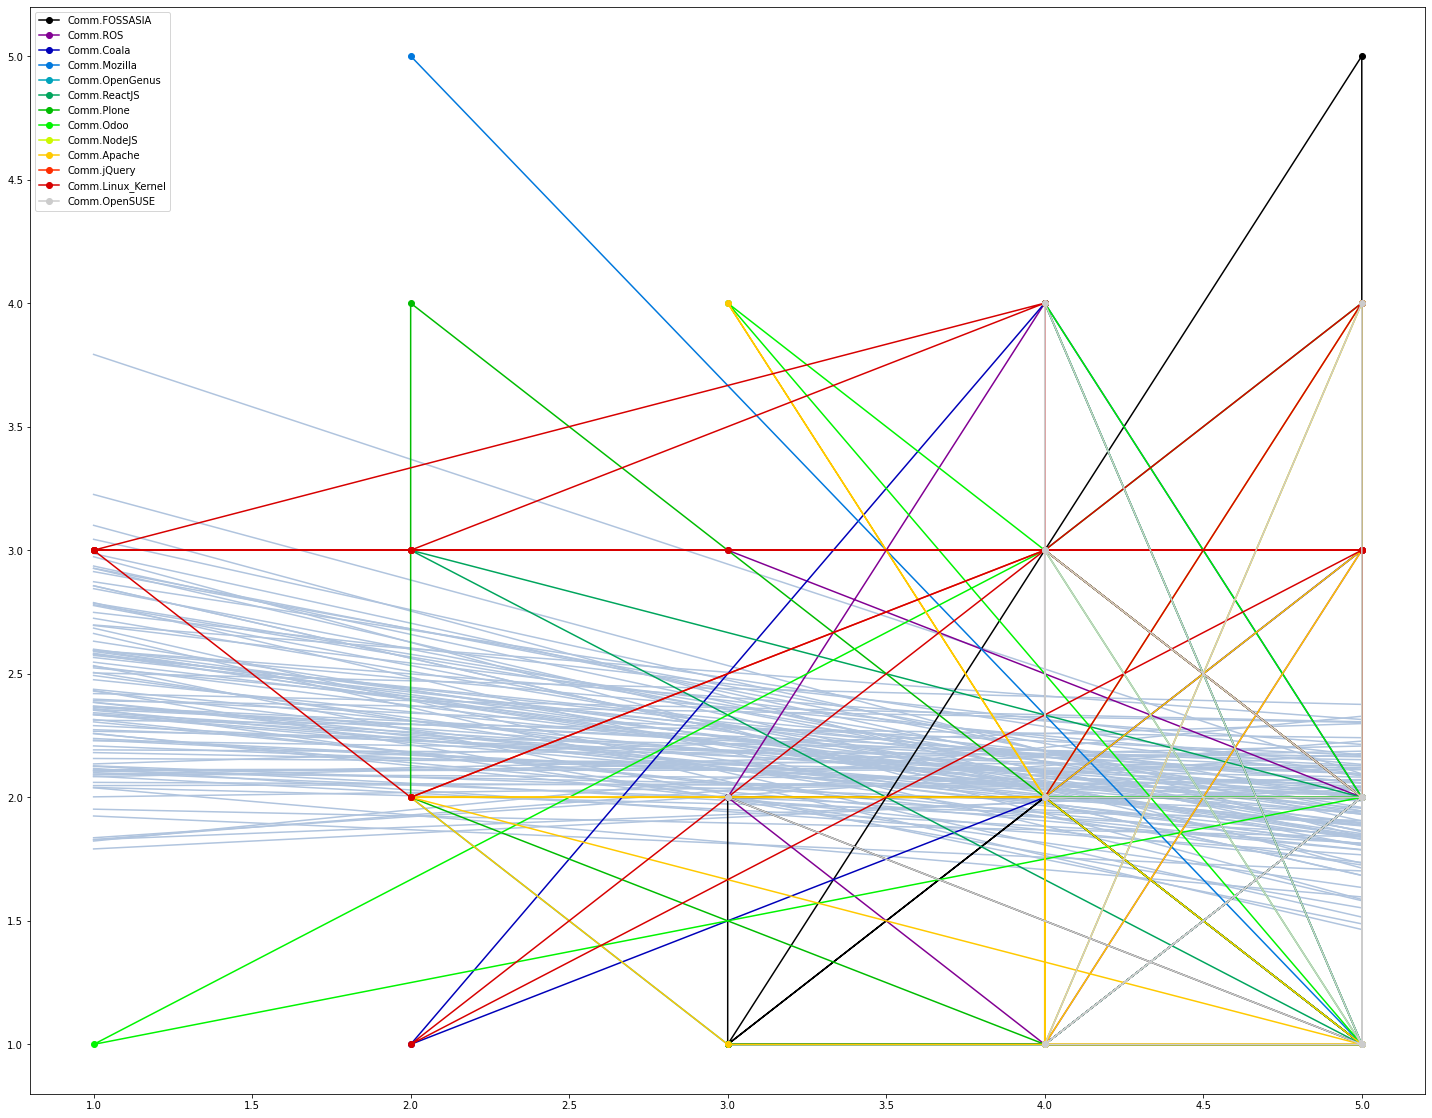

In [33]:
linFunction = lambda xprime, i: trace_h2_linear[i]['β0_group_μ']+trace_h2_linear[i]['β1_group_μ']*xprime
plot_all_data(linFunction)

In [38]:
def plot_com_reg_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], getIndexV29())[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29,
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot, 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], 2)[1], get_relevant(communities[com_id], 4)[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fun

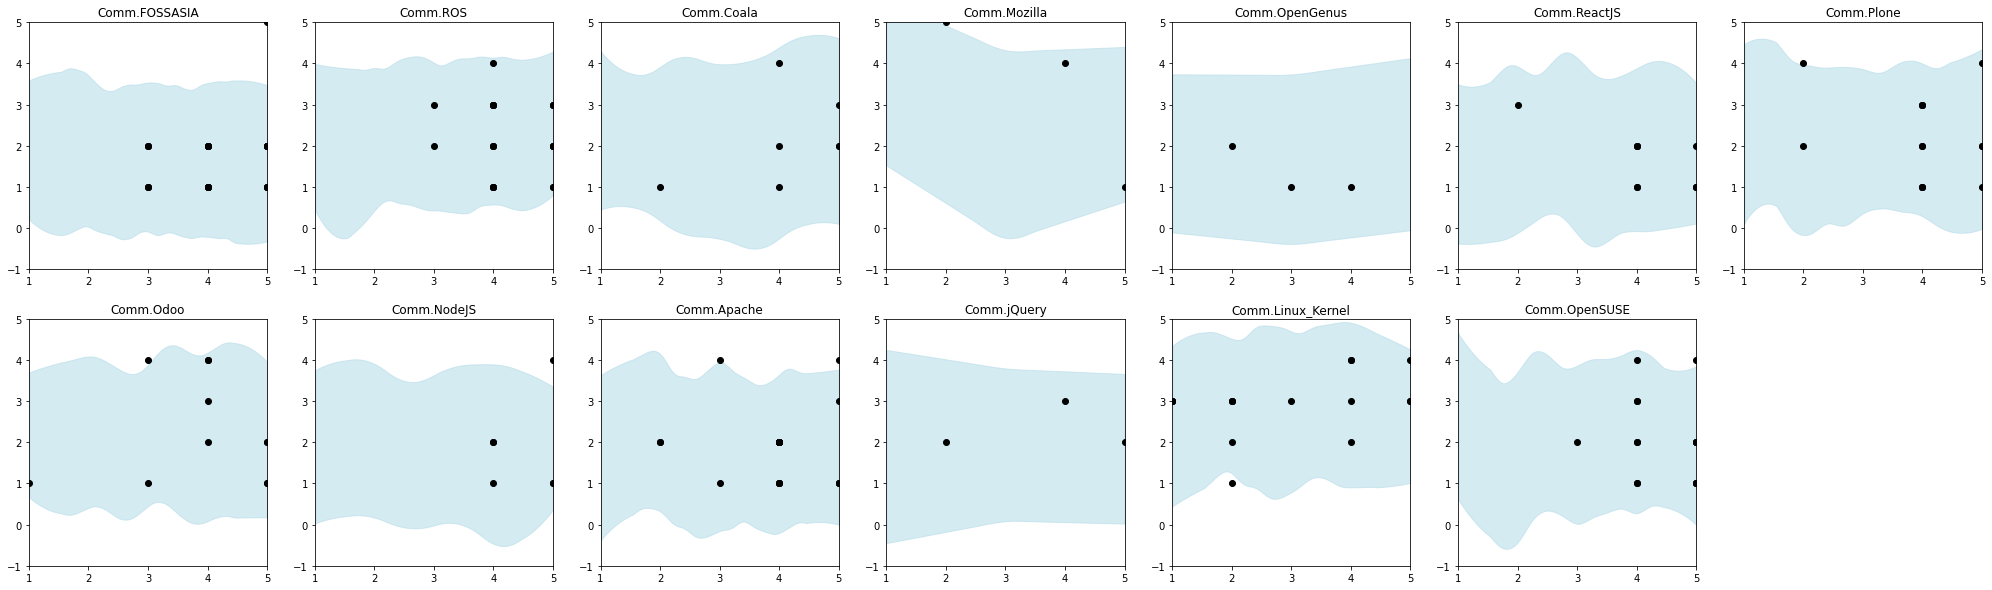

In [39]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_data(com_id=com_id,trace=trace_h2_linear,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()

### Quadratic

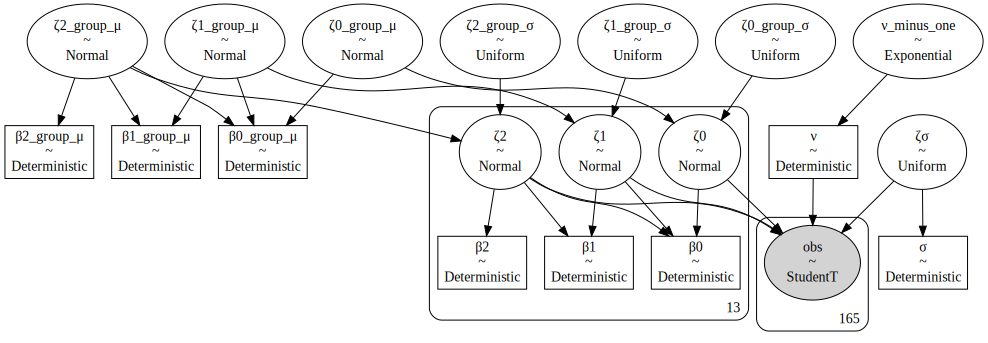

In [36]:
with pm.Model() as model_h2_quadratic:
    ζ0_group_μ = pm.Normal('ζ0_group_μ',mu=0,sigma=10)
    ζ1_group_μ = pm.Normal('ζ1_group_μ',mu=0,sigma=10)
    ζ2_group_μ = pm.Normal('ζ2_group_μ',mu=0,sigma=10)

    ζ0_group_σ = pm.Uniform('ζ0_group_σ',lower=1/1000,upper=1000)
    ζ1_group_σ = pm.Uniform('ζ1_group_σ',lower=1/1000,upper=1000)
    ζ2_group_σ = pm.Uniform('ζ2_group_σ',lower=1/1000,upper=1000)

    ζσ = pm.Uniform('ζσ',lower=1/1000,upper=1000)

    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    ζ0 = pm.Normal('ζ0',mu=ζ0_group_μ, sigma=ζ0_group_σ, shape=len(communities))
    ζ1 = pm.Normal('ζ1',mu=ζ1_group_μ, sigma=ζ1_group_σ, shape=len(communities))
    ζ2 = pm.Normal('ζ2',mu=ζ2_group_μ, sigma=ζ2_group_σ, shape=len(communities))

    pm.StudentT('obs',
                nu=ν,
                mu=ζ0[idxs]+ζ1[idxs]*V29+ζ2[idxs]*V29**2,
                sigma=ζσ,
                observed=V31)

    # Transform Data
    β2 = pm.Deterministic('β2', ζ2*sd_31/(sd_29**2))
    β1 = pm.Deterministic('β1', ζ1*sd_31/sd_29 - 2*ζ2*m_29*sd_31/(sd_29**2))
    β0 = pm.Deterministic('β0', ζ0*sd_31+m_31-ζ1*m_29*sd_31/sd_29+ζ2*(m_29**2)*sd_31/(sd_29**2))

    β2_group_μ = pm.Deterministic('β2_group_μ', ζ2_group_μ*sd_31/(sd_29**2))
    β1_group_μ = pm.Deterministic('β1_group_μ', ζ1_group_μ*sd_31/sd_29 - 2*ζ2_group_μ*m_29*sd_31/(sd_29**2))
    β0_group_μ = pm.Deterministic('β0_group_μ', ζ0_group_μ*sd_31+m_31-ζ1_group_μ*m_29*sd_31/sd_29+ζ2_group_μ*(m_29**2)*sd_31/(sd_29**2))

    σ = pm.Deterministic('σ', ζσ*sd_31)
pm.model_to_graphviz(model_h2_quadratic)

In [41]:
trace_h2_quadratic = getTrace(folderName_h2_quadratic, model_h2_quadratic, resample_h2_quadratic)  if h2_do_quadratic else None
trace_h2_inferencedata_quadratic = getInferenceData(trace_h2_quadratic, model_h2_quadratic)        if h2_do_quadratic else None

In [42]:
az.summary(trace_h2_quadratic) if h2_do_quadratic else None

C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ζ0_group_μ,0.021,0.168,-0.290,0.342,0.002,0.001,8431.0,8381.0,1.0
ζ1_group_μ,-0.142,0.133,-0.401,0.105,0.002,0.001,5458.0,12472.0,1.0
ζ2_group_μ,-0.019,0.094,-0.190,0.166,0.001,0.001,6384.0,13424.0,1.0
ζ0[0],-0.363,0.194,-0.728,-0.008,0.004,0.003,2810.0,2178.0,1.0
ζ0[1],0.113,0.192,-0.253,0.464,0.002,0.002,7153.0,13209.0,1.0
...,...,...,...,...,...,...,...,...,...
β0[12],2.002,2.635,-3.292,7.022,0.023,0.019,12356.0,13757.0,1.0
β2_group_μ,-0.018,0.085,-0.171,0.150,0.001,0.001,6384.0,13424.0,1.0
β1_group_μ,0.004,0.645,-1.205,1.245,0.007,0.005,7563.0,14329.0,1.0
β0_group_μ,2.355,1.234,0.049,4.734,0.012,0.009,9566.0,17060.0,1.0


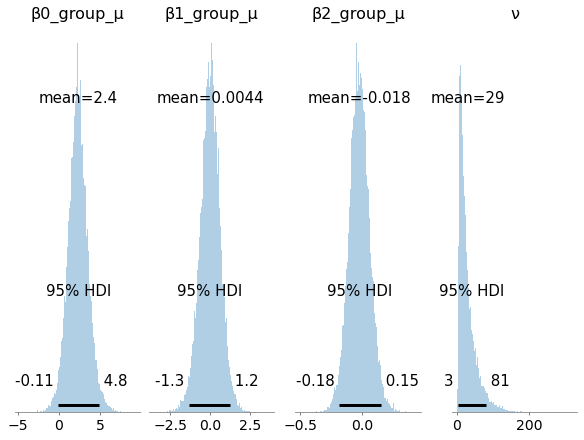

In [43]:
var_names_h2=['β0_group_μ','β1_group_μ','β2_group_μ','ν']
plot_trace_method1(trace_h2_inferencedata_quadratic, var_names_h2, [])

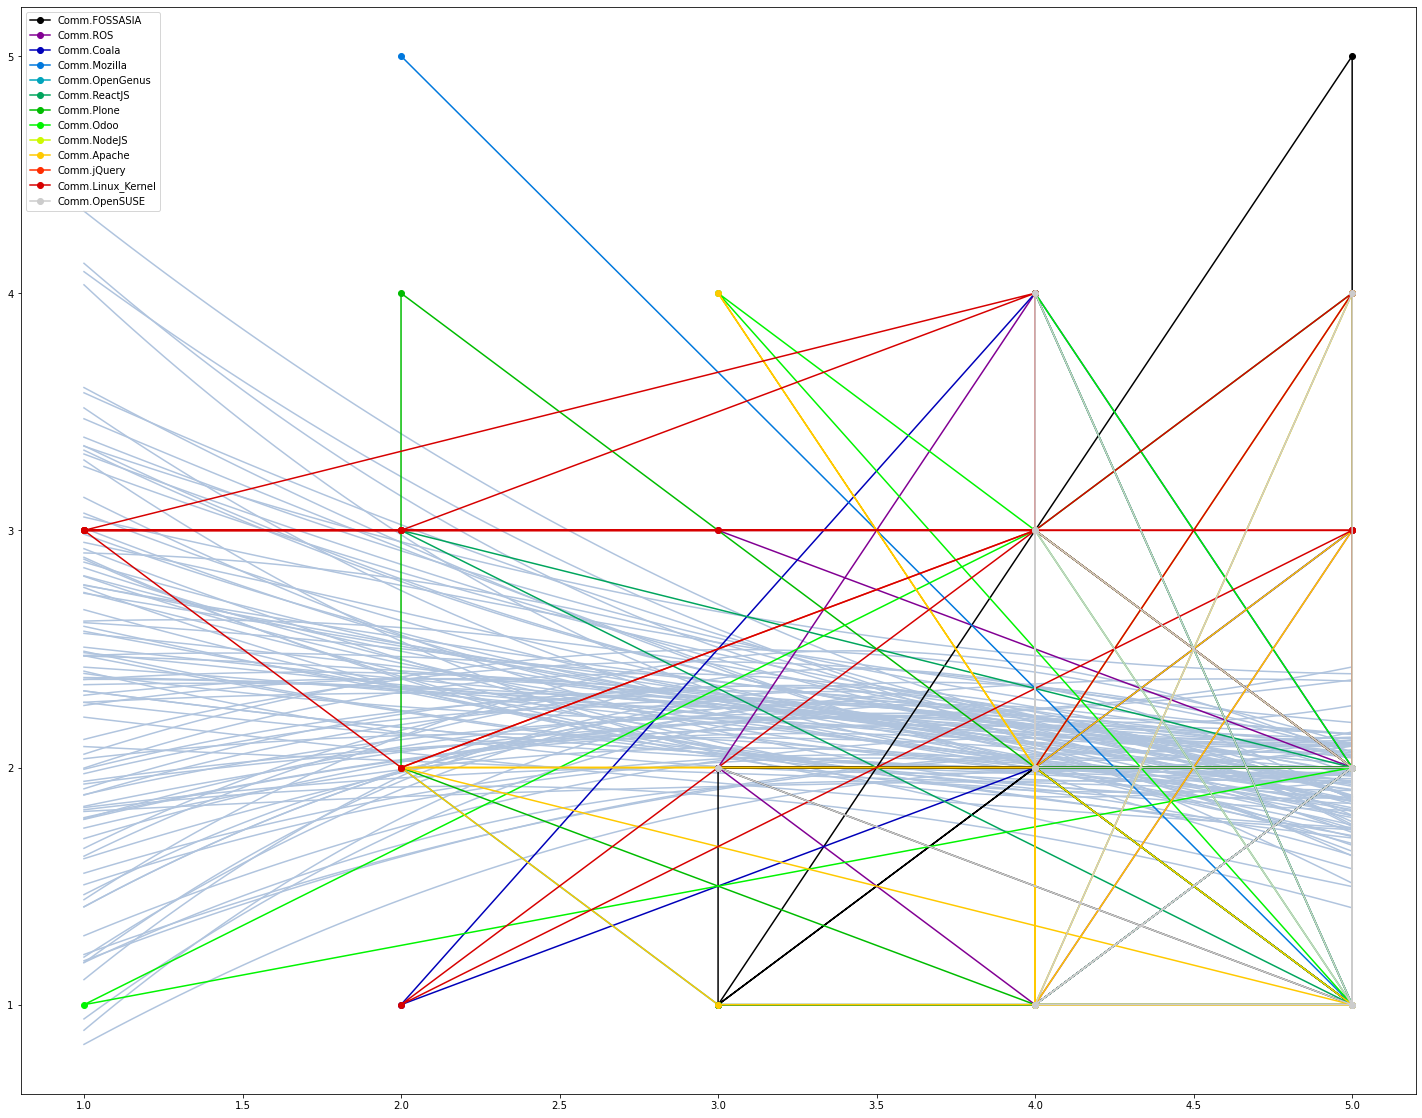

In [44]:
quadraticFunction = lambda xprime, i: trace_h2_quadratic[i]['β0_group_μ']+trace_h2_quadratic[i]['β1_group_μ']*xprime+trace_h2_quadratic[i]['β2_group_μ']*xprime**2
plot_all_data(quadraticFunction)

In [45]:
def plot_com_reg_quadratic_data(com_id,trace,num_ppc,ax,hdi=False):    
    V29_to_plot = np.array(get_relevant(communities[com_id], 2)[1])
    xprime = np.linspace(1,5,len(V29_to_plot))
    
    # Plot regression lines
    if not hdi:
        [ax.plot(xprime,
                 trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2),
                 color='lightsteelblue')
         for i in np.random.randint(0,len(trace),num_ppc)]
    
    # Plot hdi
    else:
        az.plot_hdi(xprime,
                    [t.rvs(df=trace[i]['ν'],
                           loc=trace[i]['β0'][com_id]+trace[i]['β1'][com_id]*V29_to_plot+trace[i]['β2'][com_id]*(V29_to_plot**2), 
                           scale=trace[i]['σ'])
                     for i in np.random.randint(low=0, high=len(trace), size=num_ppc)],
                    color='lightblue',
                    hdi_prob=0.95,
                    ax=ax)

    ax.plot(get_relevant(communities[com_id], 2)[1], get_relevant(communities[com_id], 4)[1],
             marker='o',linestyle=None,color='black',lw=0,
             label=communities[com_id])
#     ax.plot(get_relevant(com_id, 2)[1], get_relevant(com, 4)[1], "-", marker='o', color='black',lw=.8, label=com_id)


    ax.set_xlim(1,5)
    ax.set_ylim(-1,5)
    ax.set_title(communities[com_id])

[4 5 5 4 5 4 3 5 5 5 4 4 3 4 4 5 5 4 4 5 5 3 3 4 3 5 3 5]
[5 4 5 5 5 4 4 5 4 5 5 4 4 4 4 5 4 3 4 4 4 3 5]
[4 5 5 4 2 4 5]
[2 5 4]
[4 3 2]
[5 5 4 5 2 5 4 4 4 4]
[4 2 2 5 4 5 4 4 4 4 5 4 4 5]
[4 5 4 4 5 4 1 5 3 5 3]
[5 5 4 5 4 4]


C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other fun

[4 4 4 3 4 2 3 5 5 4 4 2 5 4 5 4 4 4 4 5 5 4]
[2 4 5]
[5 2 3 1 1 2 4 1 4 2 1 2 1 5 2 5 4 4]
[3 5 5 4 5 5 4 5 5 4 5 5 4 4 4 4 5]


C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\jisho\miniconda3\envs\prpro\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


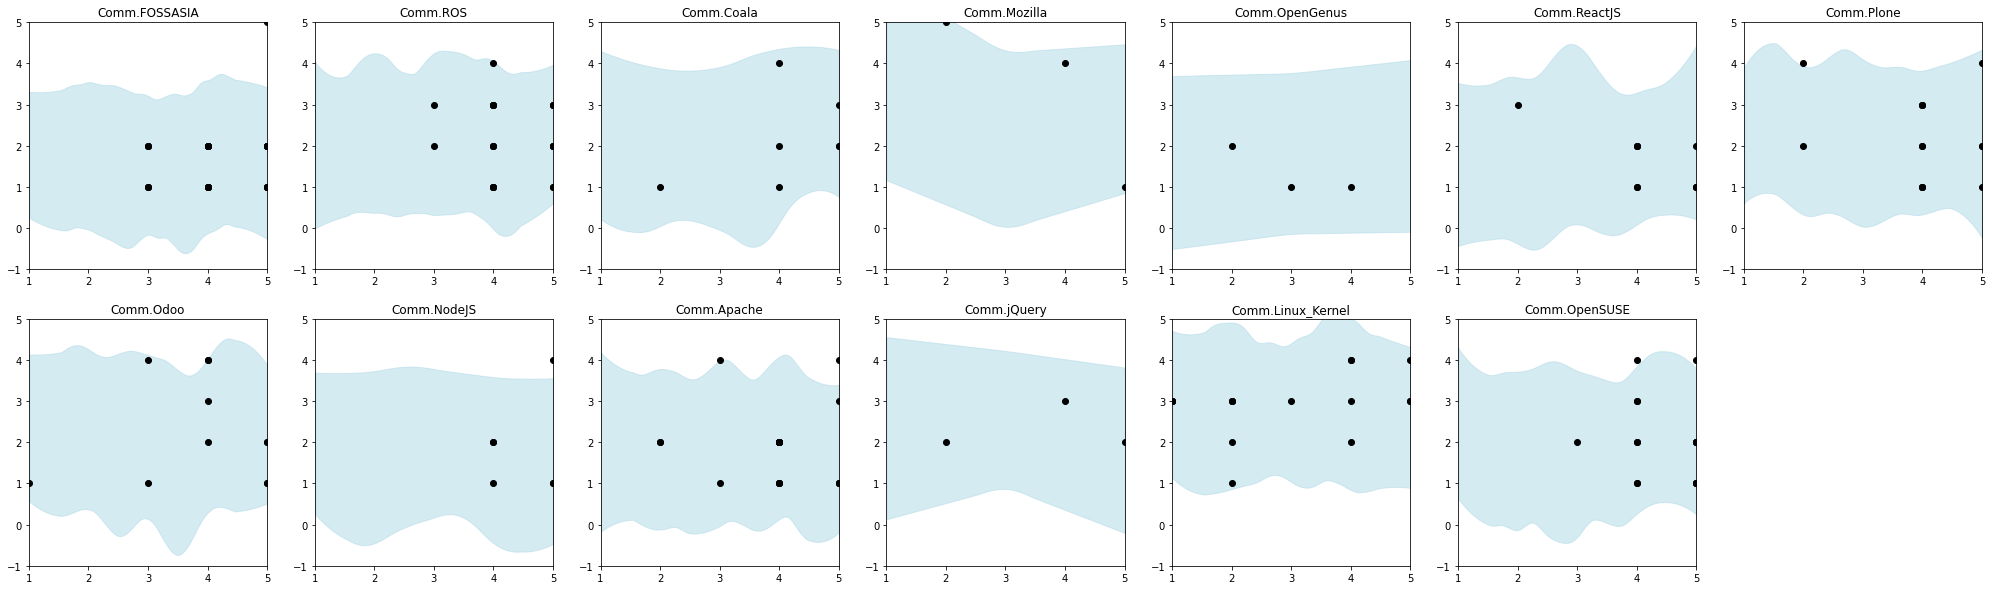

In [46]:
#plot individual
fig, axs = plt.subplots(nrows=2,ncols=7, figsize=(35,10))
flatten_axs = axs.ravel()
[plot_com_reg_quadratic_data(com_id=com_id,trace=trace_h2_quadratic,num_ppc=100,ax=ax,hdi=True) for (com_id,ax) in zip(com_ids,flatten_axs)]
[flatten_axs[i].axis('off') for i in range(len(com_ids),len(flatten_axs))]
plt.show()